In [1]:
# Data stuff
import numpy as np
import pandas as pd
import dask.dataframe as dd

# Visual stuff
from IPython.display import display
# Configs 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Random state seed
rand_state=42

# ML stuff
import sklearn
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap

# Dask
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

# Prepa data-set for models

In [2]:
# Import and display data-set
dataset = dd.read_csv('../data_gen/dataset_missing_undersample/*.part')
# Ensure correct types
dataset = dataset.astype(dtype={
    'gender':int,
    'ethnicity_AMERICAN INDIAN/ALASKA NATIVE':int,
    'ethnicity_ASIAN':int,
    'ethnicity_BLACK/AFRICAN AMERICAN':int,
    'ethnicity_HISPANIC/LATINO':int,
    'ethnicity_WHITE':int,
    'insurance_Medicaid':int,
    'insurance_Medicare':int,
    'marital_status_DIVORCED':int,
    'marital_status_MARRIED':int,
    'marital_status_SINGLE':int,
    'marital_status_WIDOWED':int,
    'language_english':int,
    'hospital_expire_flag':int,
})
# Order ints(categorical variables) and floats(number variables)
dataset = dataset[[
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_ASIAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_HISPANIC/LATINO',
 'ethnicity_WHITE',
 'insurance_Medicaid',
 'insurance_Medicare',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_status_WIDOWED',
 'gender',
 'language_english',
 'hospital_expire_flag',
 'age_at_admission',
 'seq_num',
 'times_prev_admitted',
 'length_of_stay(days)',
 'BMI',
 'Glucose',
 'Potassium',
 'Sodium',
 'Chloride',
 'Bicarbonate',
 'Anion Gap',
 'Creatinine',
 'Urea Nitrogen',
 'Magnesium',
 'Hematocrit',
 'Hemoglobin',
 'Platelet Count',
 'Phosphate',
 'Calcium, Total',
 'White Blood Cells',
 'Red Blood Cells',
 'MCH',
 'RDW',
 'MCV',
 'pH',
 'PTT',
 'PT',
 'H'
]].compute()

In [3]:
# Generate data set withouth categories(all numbers)
Y_no_cat = dataset.hospital_expire_flag.values
X_no_cat = dataset.drop(columns=['hospital_expire_flag']).values

# dataset as is, but target variable dropped(hospital expire flag)
dataset_no_target = dataset.drop(columns=['hospital_expire_flag'])

# Feture names and categorical feature names
feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() + dataset_no_target.select_dtypes(exclude='int').columns.values.tolist() 
cat_feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() 

# Generate data set with categories(int type required)
dataframe_int_list = dataset_no_target.select_dtypes(include='int').values.tolist()
dataframe_no_int_list = dataset_no_target.select_dtypes(exclude='int').values.tolist()
Y = dataset.hospital_expire_flag.values.tolist()
X = []
for i,v in enumerate(dataframe_int_list):
    X = X + [v+dataframe_no_int_list[i]]

# Generate categorical feature indicies
cat_features_indices=list(range(0,len(dataframe_int_list[0])))

# Define functions and variables

In [4]:
# Function that w
def strat_cv_it(classifier, params, uses_cat, param_comb ):
    folds = 3
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = rand_state)
    
    # Perform fit and scoring
    if uses_cat:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X, Y),random_state = rand_state, refit=True, verbose=3,  )
        random_search.fit(X, Y)     
    else:
        random_search = RandomizedSearchCV( classifier, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X_no_cat, Y_no_cat),random_state = rand_state, refit=True, verbose=3)
        random_search.fit(X_no_cat, Y_no_cat)
    
    # Display results and return best model
    display(random_search.best_score_)
    display(random_search.best_params_)
    display(pd.DataFrame(random_search.cv_results_))
    return random_search.best_estimator_

# Models

## XGBOOST

In [5]:
xgb_classifier = xgb.XGBClassifier(objective = "binary:logistic",random_state=rand_state)
xgb_params = {
        'learning_rate': (0.01, 0.05,0.1),
        'min_child_weight': [3, 5, 10],
        'gamma': [0.5, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': list(range(5,30)),
        'scale_pos_weight':  [0.5,0.75,0.9,1, 1.1, 1.25,1.5]
}
model = strat_cv_it(xgb_classifier ,xgb_params,False,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   45.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   54.2s finished


0.8535141950855115

{'subsample': 0.8,
 'scale_pos_weight': 1,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 1.5,
 'colsample_bytree': 1.0}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.044530      0.020456         0.010306    4.703592e-04   
1        0.618346      0.093901         0.007979    8.144907e-04   
2        1.187823      0.005873         0.015624    4.704151e-04   
3        1.163887      0.032050         0.012300    3.290489e-03   
4        1.992004      0.065674         0.013963    1.629176e-03   
5        2.186484      0.029409         0.015293    4.696284e-04   
6        1.241678      0.022137         0.017287    3.290714e-03   
7        2.343398      0.065760         0.012632    4.702465e-04   
8        1.329776      0.106037         0.024601    9.952009e-03   
9        1.512953      0.080238         0.016290    3.672354e-03   
10       1.431172      0.006958         0.011968    2.154572e-03   
11       1.673191      0.013537         0.017287    9.401557e-04   
12       2.281563      0.189905         0.023936    1.340547e-02   
13       1.119339      0.024891         0.020611    1.298613e-02   
14       1.016281      0.019543         0.008976    8.140041e-04   
15       1.210428      0.030537         0.013630    4.705275e-04   
16       0.599065      0.015586         0.010638    4.707522e-04   
17       1.335428      0.016019         0.016622    4.701340e-04   
18       1.918202      0.022007         0.010638    9.403805e-04   
19       1.177849      0.016287         0.015292    1.244176e-03   
20       1.423192      0.021591         0.017620    9.403244e-04   
21       0.882639      0.005086         0.008976    4.052337e-07   
22       1.994000      0.029990         0.015957    8.143935e-04   
23       0.785233      0.011782         0.009308    4.703027e-04   
24       1.223394      0.001695         0.011636    1.695934e-03   
25       1.208102      0.011294         0.011635    9.406615e-04   
26       1.446131      0.035987         0.013963    2.154498e-03   
27       0.896934      0.038337         0.018284    8.933053e-03   
28       1.945795      0.015536         0.017287    4.016314e-03   
29       1.442474      0.042815         0.011636    4.703588e-04   
30       1.702778      0.059117         0.015292    4.701903e-04   
31       0.687826      0.019293         0.009309    1.243688e-03   
32       1.236360      0.015881         0.010638    1.243794e-03   
33       1.200123      0.019886         0.016954    1.410346e-03   
34       0.888955      0.004975         0.012965    8.139067e-04   
35       1.140284      0.020493         0.021608    6.165476e-03   
36       1.393272      0.030740         0.014295    3.290842e-03   
37       1.652247      0.107928         0.009308    4.705837e-04   
38       1.027917      0.004099         0.014960    0.000000e+00   
39       1.216080      0.007523         0.015625    4.701340e-04   
40       0.650592      0.003083         0.009308    4.700779e-04   
41       1.504309      0.020926         0.013962    2.820692e-03   
42       0.900591      0.032665         0.011635    4.708646e-04   
43       1.212091      0.070188         0.014628    4.700217e-04   
44       1.117345      0.018324         0.013630    9.400995e-04   
45       1.920197      0.034107         0.013962    9.602742e-07   
46       1.349058      0.018576         0.014627    1.880649e-03   
47       1.250322      0.107448         0.014960    2.154683e-03   
48       1.199126      0.003848         0.010638    9.402681e-04   
49       0.754315      0.006112         0.010305    1.880030e-03   

   param_subsample param_scale_pos_weight param_min_child_weight  \
0              0.8                   1.25                      5   
1              0.6                   0.75                     10   
2                1                    1.5                      5   
3              0.8                    0.5                     10   
4              0.8                   1.25                      5   
5                1                    0.5                      3   
6              0.8                    0.9                  

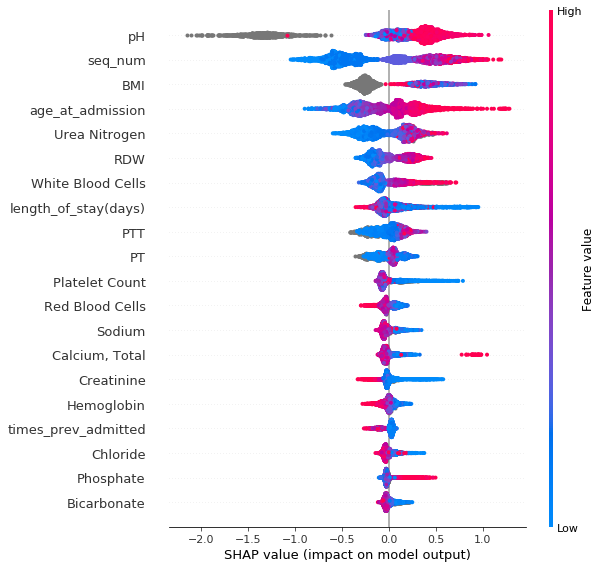

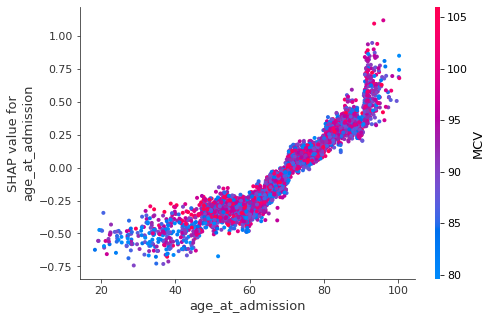

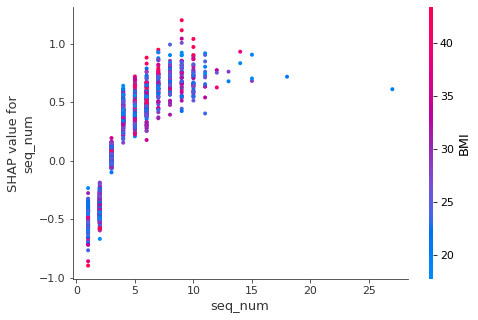

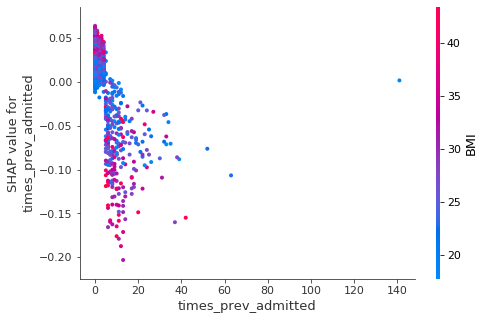

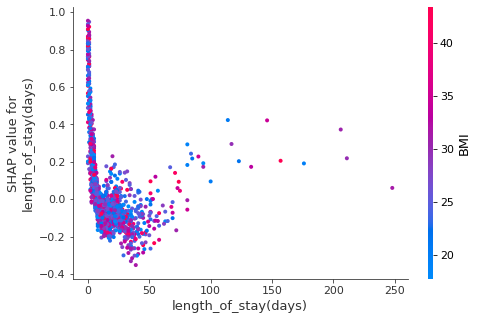

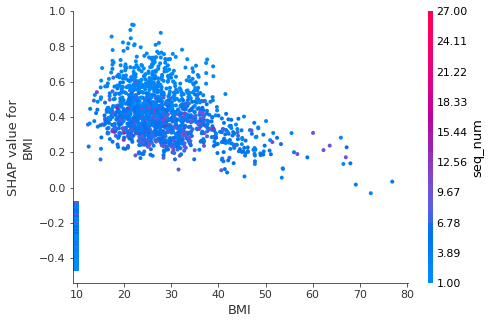

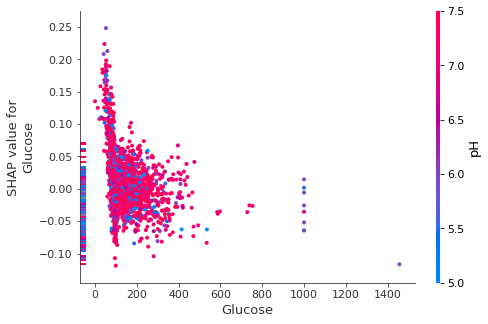

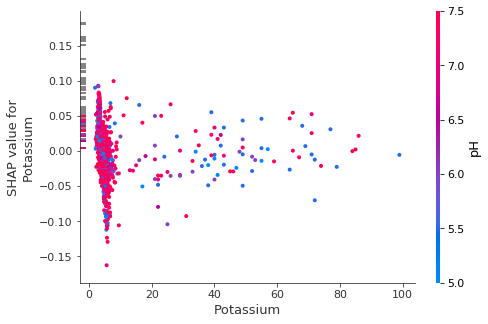

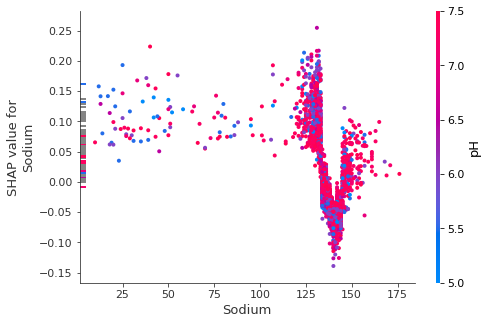

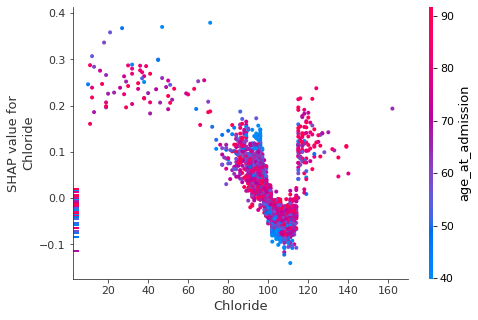

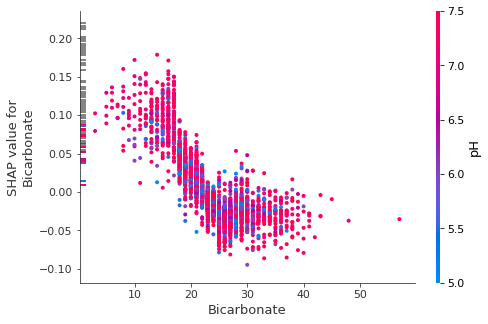

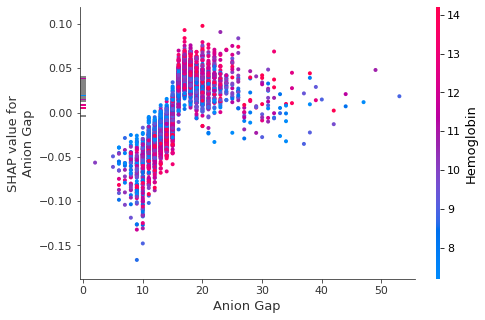

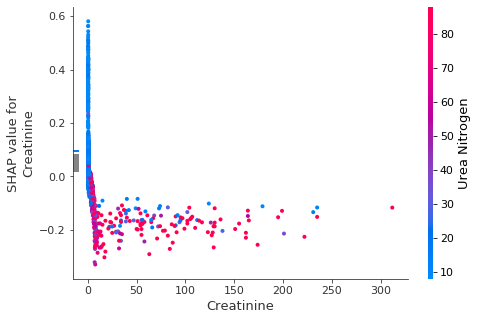

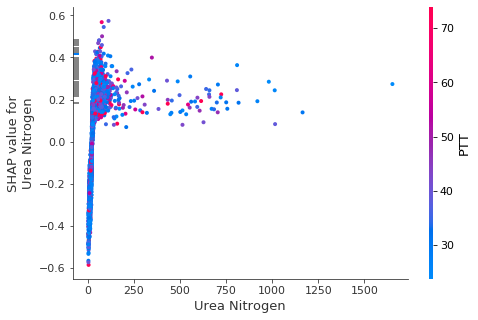

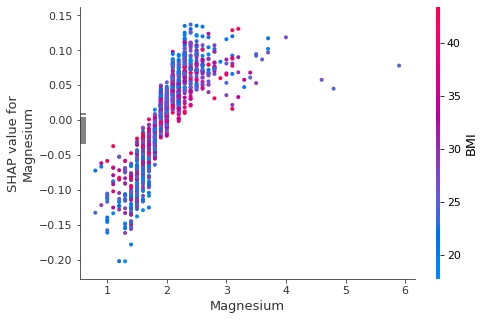

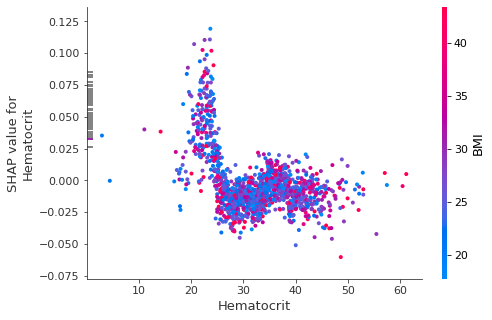

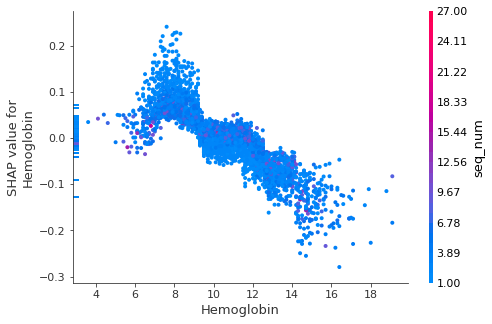

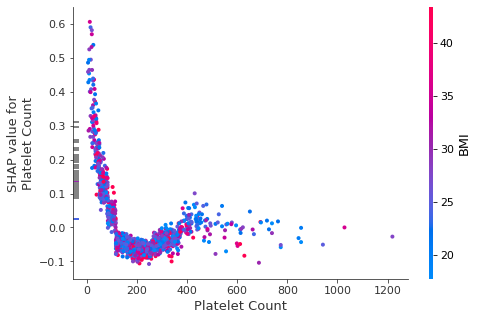

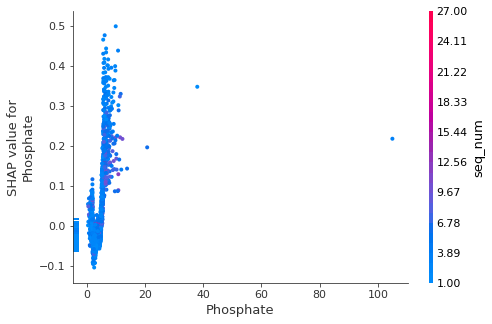

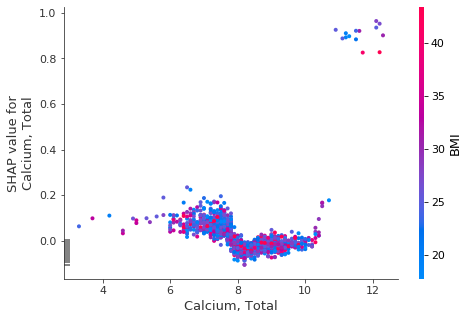

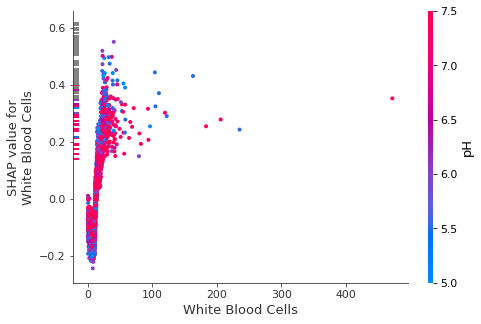

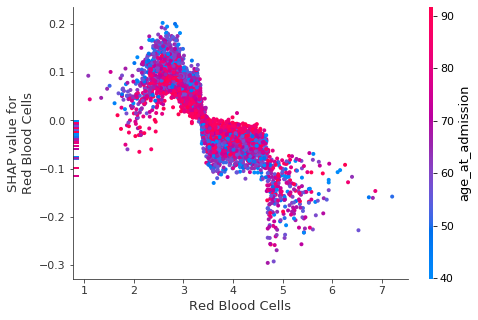

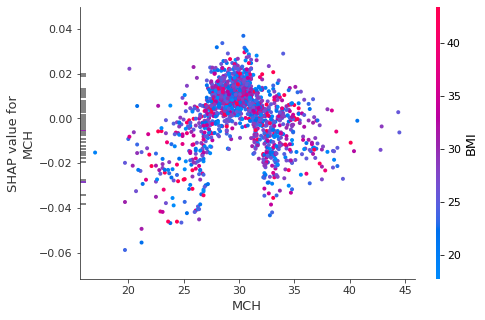

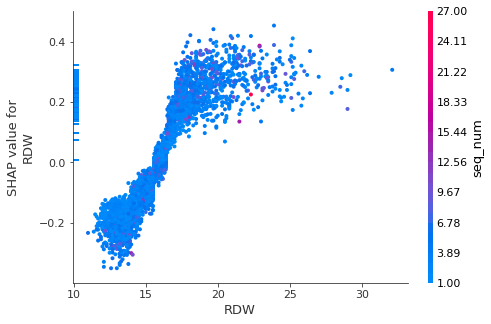

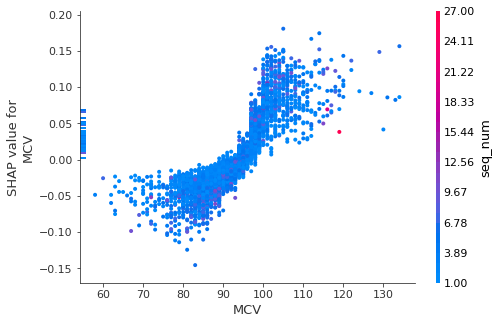

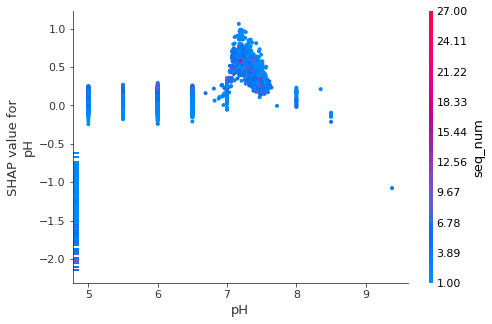

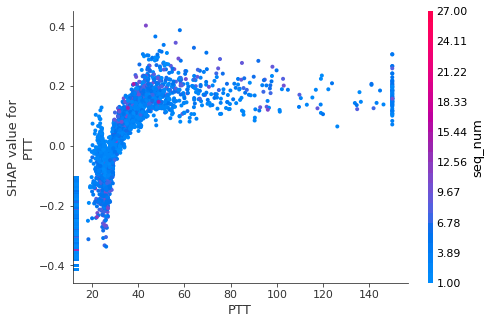

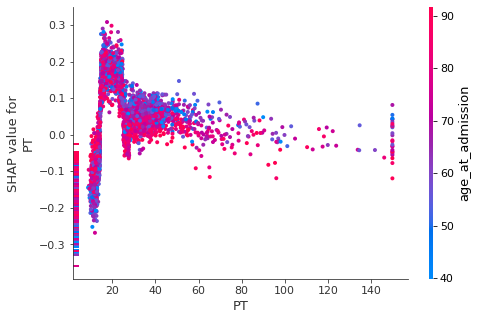

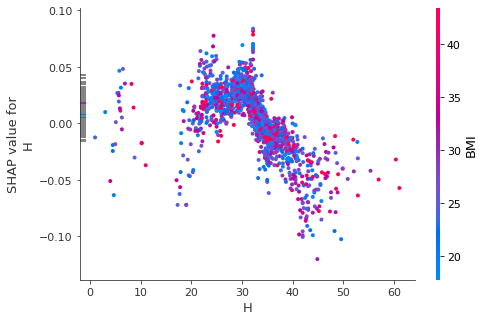

In [6]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values,X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values,X_no_cat ,feature_names=feature_names)

# CatBoost

In [7]:
CB_classifier = CatBoostClassifier(
     cat_features=cat_features_indices,
     verbose=False,
     early_stopping_rounds=50,
)
CB_params = {
        'learning_rate': [0.05, 0.1],
        'depth': [4,5,6,7,8,9],
        'l2_leaf_reg': [1, 3, 5, 7, 8],
        'scale_pos_weight':  [0.5,0.75,0.9,1, 1.1, 1.25,1.5]

} 
# Note Attention: (ignore, affects speed(not result quality))
# Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality.
model = strat_cv_it(CB_classifier ,CB_params,True,25)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  9.3min finished


0.8547415882974612

{'scale_pos_weight': 1.1, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'depth': 8}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       16.506841      1.111106         0.289559        0.073714   
1       39.437498      0.746834         0.282577        0.057663   
2       18.851237      0.324036         0.339425        0.066067   
3       79.769271      0.475846         0.426858        0.058500   
4       71.233771      5.504059         0.313495        0.175485   
5       15.734241      0.712722         0.435502        0.146614   
6       15.679388      0.215012         0.541219        0.149547   
7       13.172760      2.163838         0.157911        0.020117   
8        8.467016      0.179426         0.206448        0.070822   
9       11.306752      0.059278         0.169214        0.020622   
10      11.325369      0.178119         0.186834        0.038284   
11      12.681741      2.368309         0.215092        0.028083   
12      72.915936      0.638032         0.281913        0.040037   
13      16.680045      0.612797         0.233708        0.038207   
14      45.524548      0.796824         0.221408        0.044094   
15      70.207184      1.247705         0.220743        0.040424   
16      12.847630      0.518185         0.224068        0.042566   
17      27.215860      1.302674         0.174533        0.020552   
18      16.835629      0.121793         0.172870        0.036073   
19      24.941610      0.604176         0.157579        0.026996   
20      17.522458      0.710030         0.173536        0.045398   
21      26.522381      1.482886         0.196475        0.023615   
22      41.896254      0.146653         0.172206        0.017396   
23      23.961898      3.724294         0.127659        0.043159   
24       8.887558      1.828400         0.142951        0.081205   

   param_scale_pos_weight param_learning_rate param_l2_leaf_reg param_depth  \
0                    1.25                0.05                 1           6   
1                    1.25                 0.1                 7           8   
2                     0.5                 0.1                 5           6   
3                    1.25                0.05                 3           9   
4                       1                 0.1                 8           9   
5                       1                0.05                 1           5   
6                     1.5                0.05                 8           5   
7                     1.1                 0.1                 8           5   
8                     0.9                0.05                 5           4   
9                     0.9                0.05                 1           5   
10                    0.5                0.05                 1           5   
11                      1                 0.1                 3           5   
12                    1.1                0.05                 3           9   
13                    1.5                0.05                 3           5   
14                    1.1                0.05                 7           8   
15                    1.5                0.05                 8           9   
16                    0.9                 0.1                 1           4   
17                    0.9                 0.1                 5           7   
18                    0.5                0.05                 8           6   
19                    0.5                 0.1                 3           7   
20                      1                 0.1                 7           6   
21                   0.75                0.05                 5           7   
22                    1.1                 0.1                 8           8   
23                    1.1                0.05                 3           7   
24                    1.5                 0.1                 7           4   

                                               params  split0_test_score  \
0   {'scale_pos_weight': 1.25, 'learning_rate': 0....           0.855664   
1   {'scale_pos_weight': 1.2

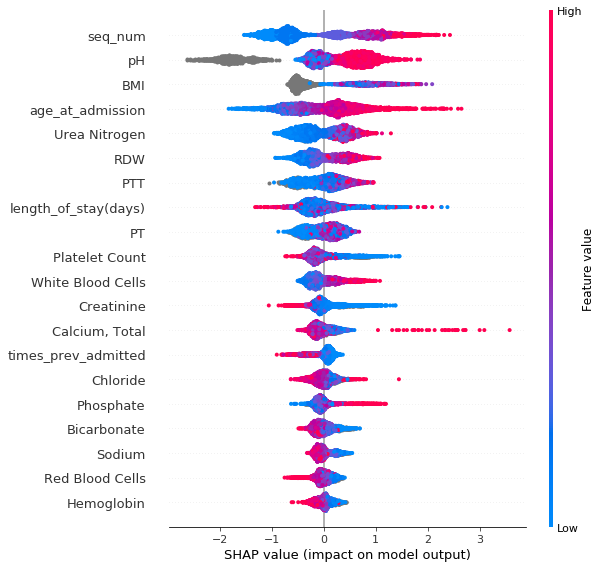

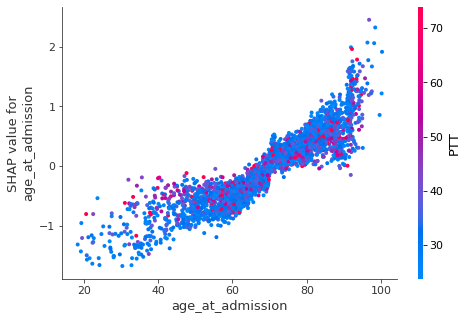

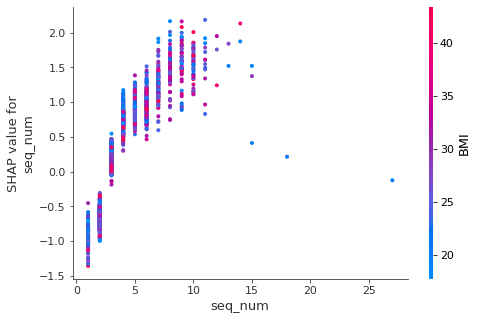

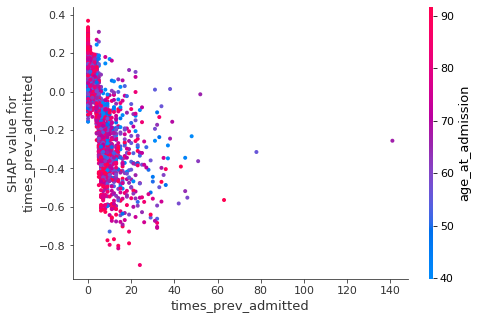

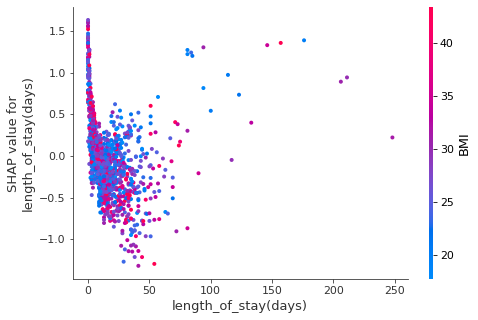

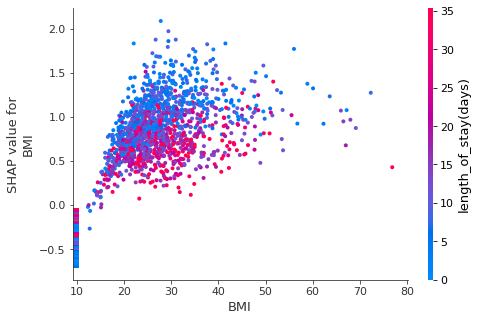

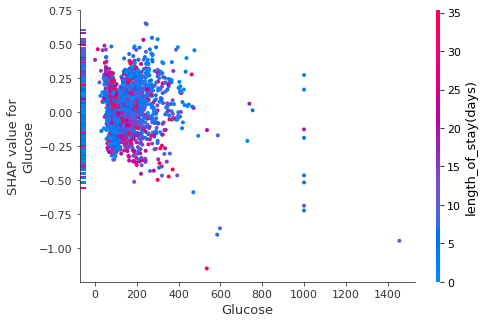

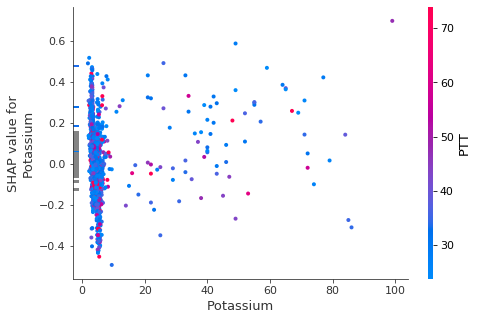

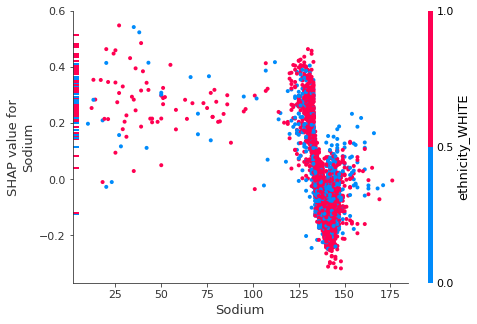

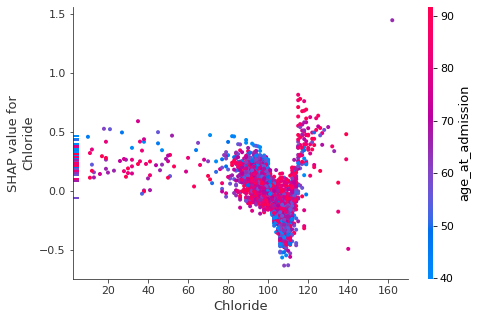

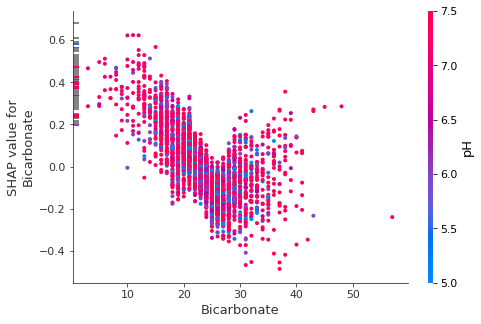

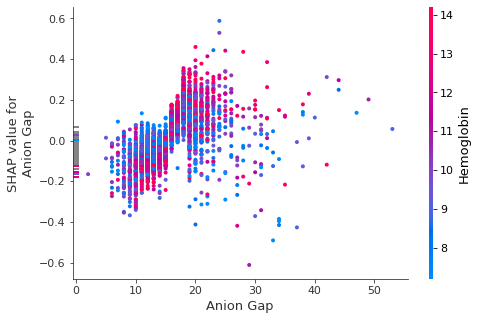

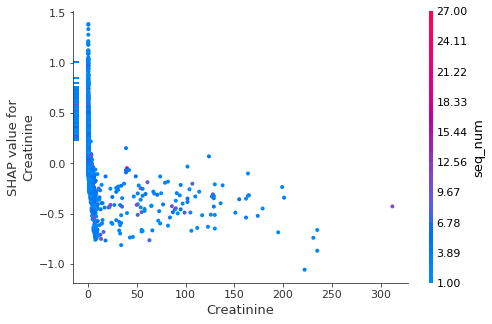

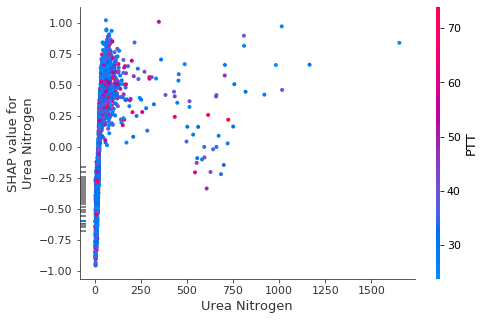

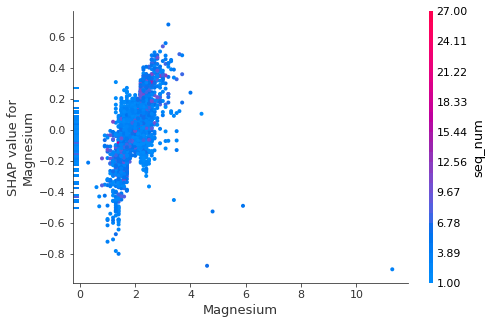

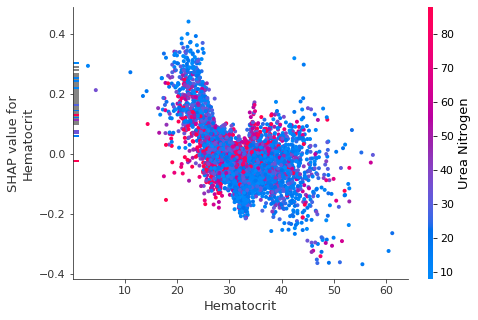

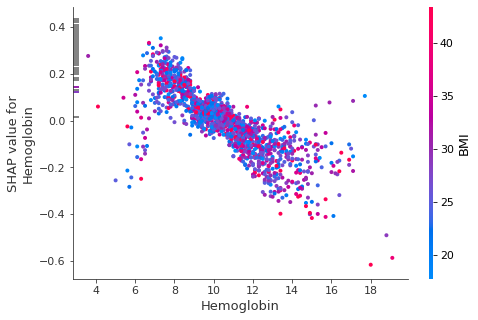

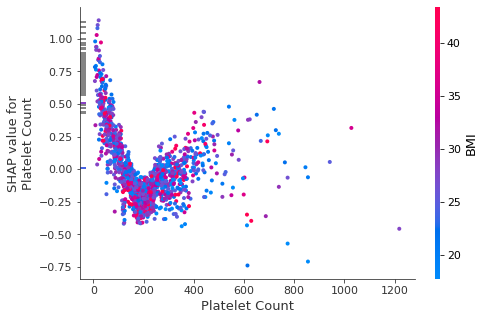

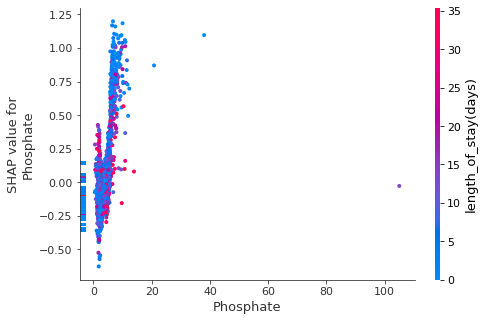

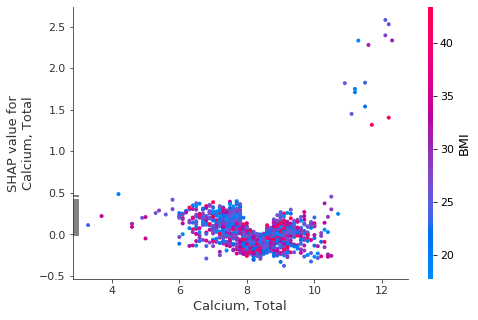

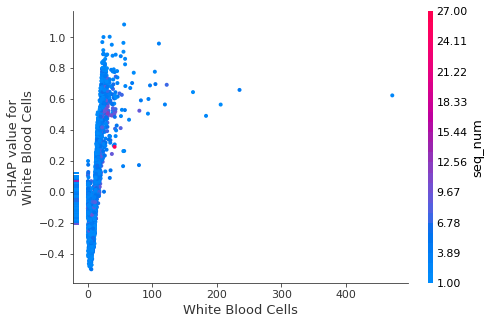

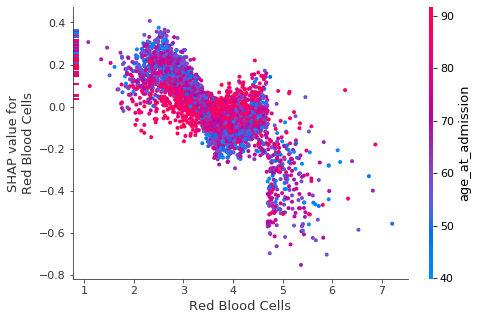

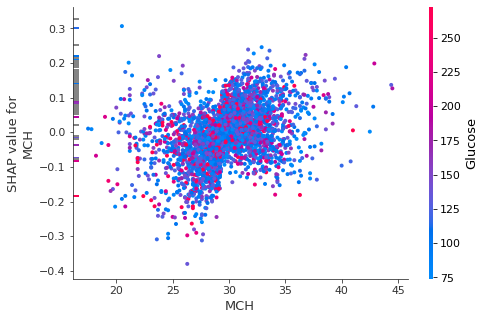

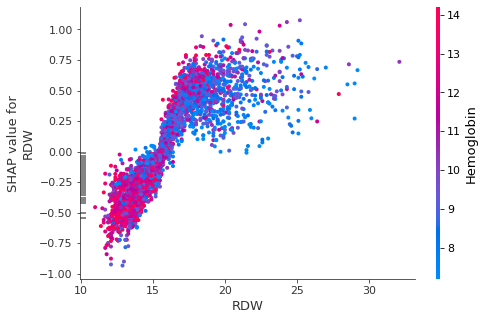

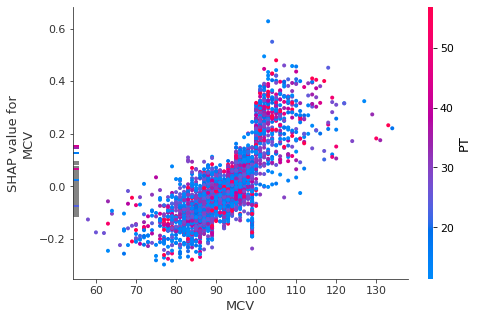

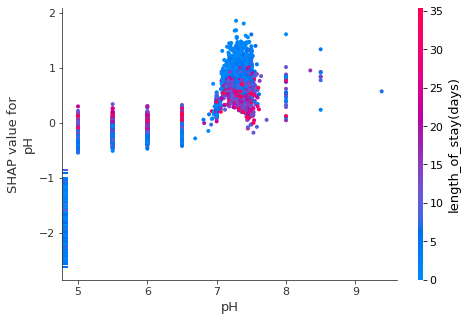

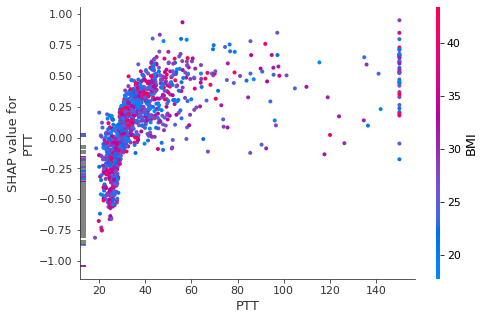

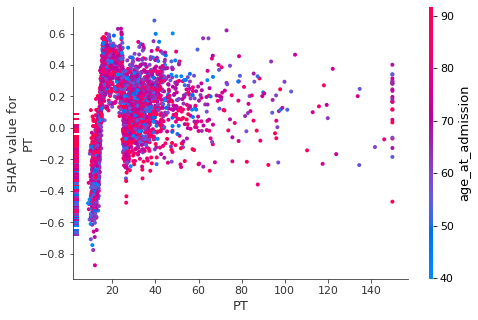

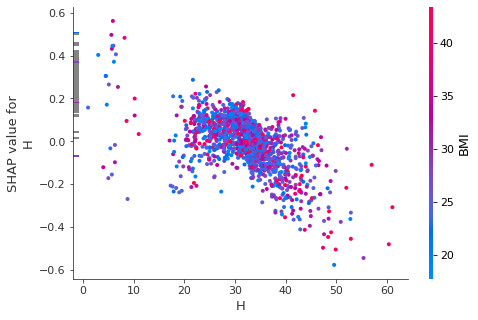

In [8]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values, dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values ,dataset_no_target ,feature_names=feature_names)

# LightGBM

In [9]:
LGB_classifier = lgb.LGBMClassifier()
LGB_params = {
             'num_leaves': [1,5,8,10,15,20,35,40], 
             'min_child_samples': [1,5,10,20,50,100,200,300,400,500], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': [0.2,0,4,0.5, 0.6, 0.8, 1.0],
             'colsample_bytree': [0.6, 0.8, 1.0],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'scale_pos_weight':  [0.5,0.75,0.9,1, 1.1, 1.25,1.5]

}
model = strat_cv_it(LGB_classifier ,LGB_params,True,50)
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   35.3s finished


0.8502006802797085

{'subsample': 0.2,
 'scale_pos_weight': 0.9,
 'reg_lambda': 20,
 'reg_alpha': 1,
 'num_leaves': 20,
 'min_child_weight': 0.1,
 'min_child_samples': 1,
 'colsample_bytree': 0.6}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.088098  1.243645e-03         0.011303    4.699655e-04   
1        0.104048  3.295725e-03         0.013298    4.700779e-04   
2        0.178530  8.143521e-04         0.016616    9.450809e-04   
3        0.018617  4.702468e-04         0.000000    0.000000e+00   
4        0.068483  1.694531e-03         0.012302    4.685664e-04   
5        0.040565  4.748670e-04         0.006325    4.641300e-04   
6        0.071468  4.645537e-04         0.012309    4.831715e-04   
7        0.018597  4.698531e-04         0.000000    0.000000e+00   
8        0.035578  4.748670e-04         0.006326    4.681386e-04   
9        0.087089  4.780712e-04         0.012633    4.699655e-04   
10       0.103406  1.253831e-03         0.016281    4.756174e-04   
11       0.019938  8.147897e-04         0.000000    0.000000e+00   
12       0.019274  4.622747e-04         0.000000    0.000000e+00   
13       0.040234  4.784542e-04         0.006642    4.651962e-04   
14       0.019275  4.751530e-04         0.000000    0.000000e+00   
15       0.018285  1.243348e-03         0.000000    0.000000e+00   
16       0.019608  4.657102e-04         0.000000    0.000000e+00   
17       0.092759  2.148660e-03         0.013957    8.058496e-04   
18       0.018936  8.151256e-04         0.000000    0.000000e+00   
19       0.040547  9.484639e-04         0.005984    1.606256e-05   
20       0.070816  1.136934e-05         0.011296    9.498565e-04   
21       0.054180  9.485915e-04         0.009308    4.565179e-04   
22       0.043882  5.947204e-07         0.006337    4.701340e-04   
23       0.037227  4.752109e-04         0.005991    9.673515e-06   
24       0.039906  8.064255e-04         0.006977    1.134654e-05   
25       0.089774  1.005952e-05         0.011636    4.706110e-04   
26       0.018943  8.056496e-04         0.000000    0.000000e+00   
27       0.018617  1.243837e-03         0.000000    0.000000e+00   
28       0.353714  3.387251e-03         0.018617    9.400996e-04   
29       0.018610  4.654960e-04         0.000000    0.000000e+00   
30       0.019605  4.776125e-04         0.000000    0.000000e+00   
31       0.154267  1.876059e-03         0.014960    2.973602e-07   
32       0.018943  9.105800e-06         0.000000    0.000000e+00   
33       0.343747  2.633661e-03         0.018610    4.651517e-04   
34       0.018601  9.316465e-04         0.000000    0.000000e+00   
35       0.019614  4.703027e-04         0.000000    0.000000e+00   
36       0.018605  4.619911e-04         0.000000    0.000000e+00   
37       0.058184  4.801378e-04         0.008637    9.454216e-04   
38       0.105731  2.145045e-03         0.011622    4.750406e-04   
39       0.020598  4.747546e-04         0.000000    0.000000e+00   
40       0.073477  2.050475e-03         0.008970    8.221960e-04   
41       0.018943  1.415428e-03         0.000000    0.000000e+00   
42       0.070816  8.061521e-04         0.010964    9.780006e-06   
43       0.071143  4.559408e-04         0.011969    1.664496e-05   
44       0.081782  1.637220e-03         0.012958    9.555269e-06   
45       0.019282  4.721571e-04         0.000000    0.000000e+00   
46       0.019271  4.775662e-04         0.000000    0.000000e+00   
47       0.078451  4.665663e-04         0.011977    2.043210e-05   
48       0.019272  9.337603e-04         0.000000    0.000000e+00   
49       0.082453  3.281497e-03         0.012288    9.454769e-04   

   param_subsample param_scale_pos_weight param_reg_lambda param_reg_alpha  \
0              0.2                    0.5               50              50   
1              0.8                    0.5               50               5   
2                1                      1              0.1              10   
3                1                    0.9               50              10   
4              0.5                   1.25              0.1              50   
5                1                    0.9                0         

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


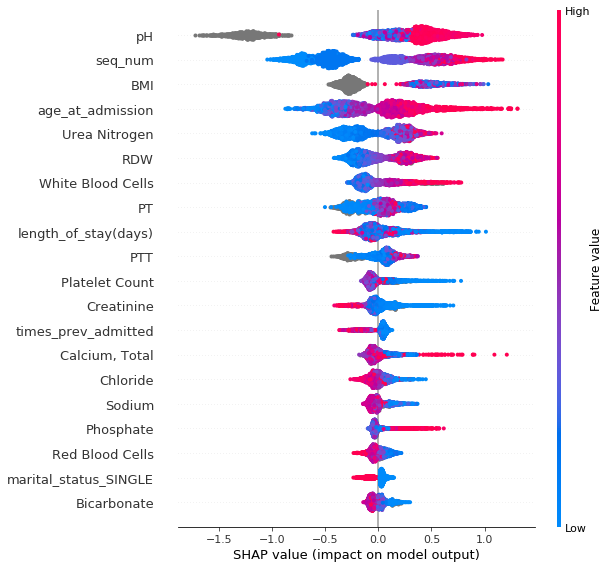

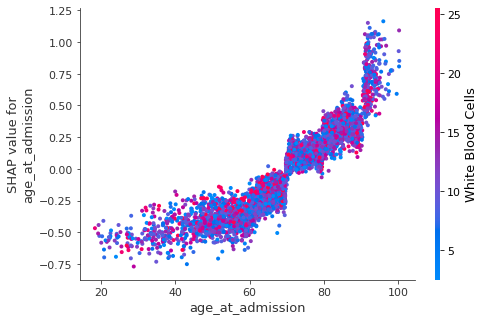

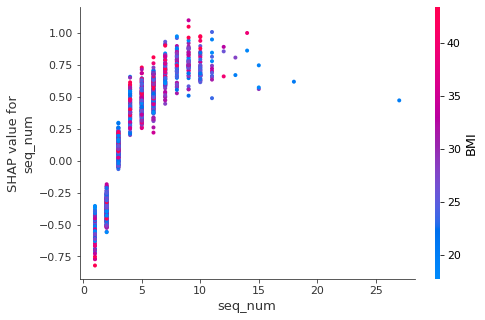

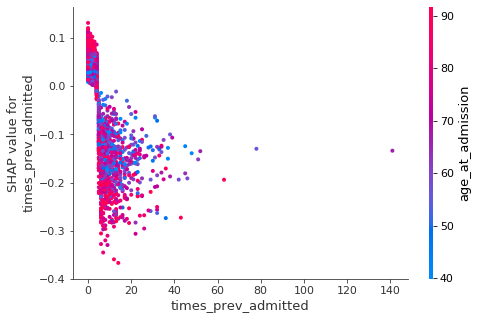

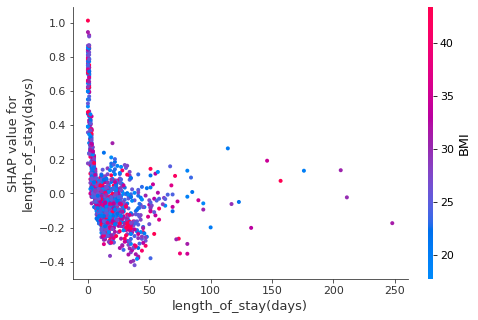

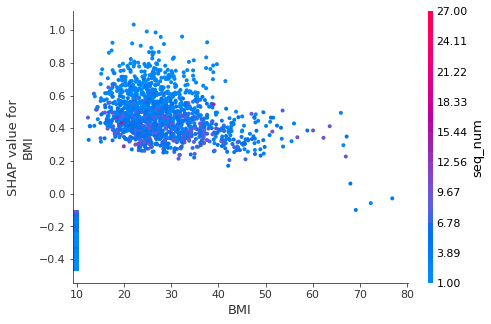

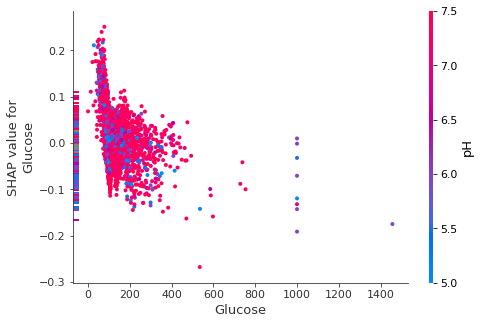

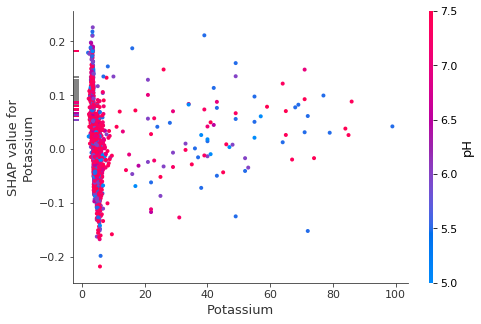

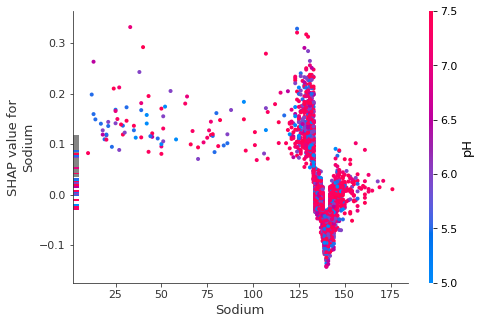

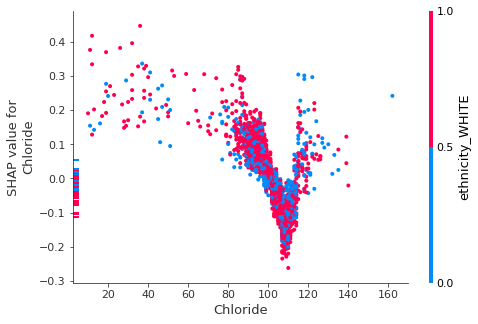

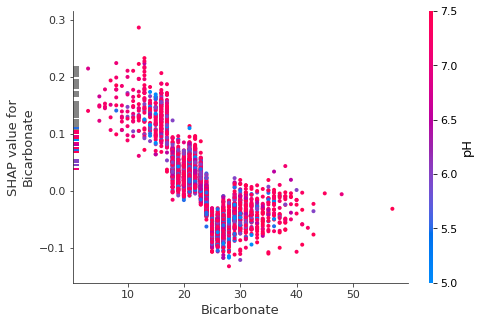

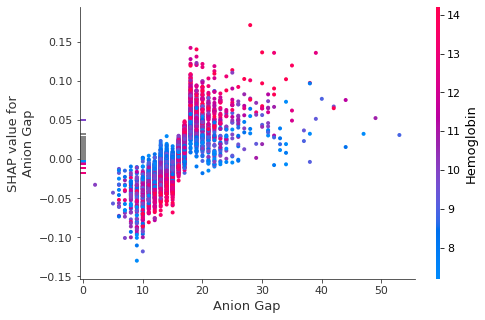

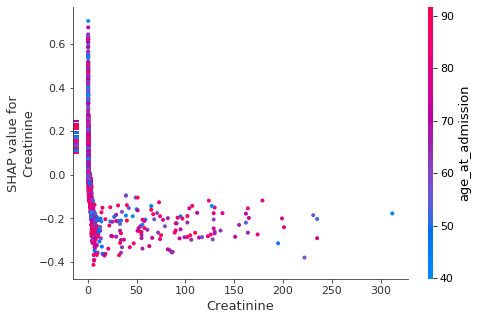

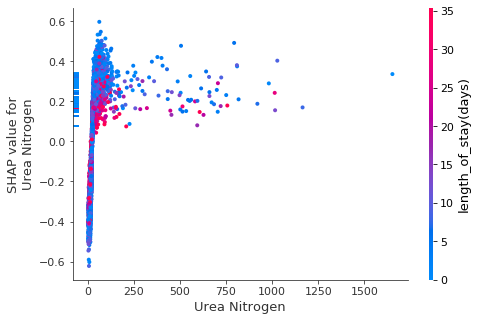

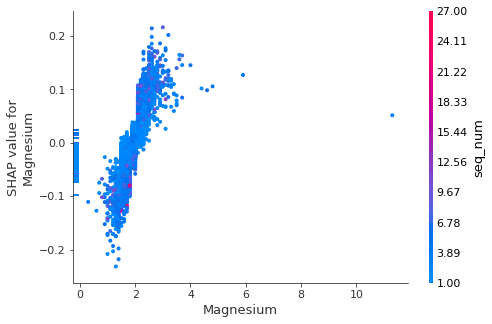

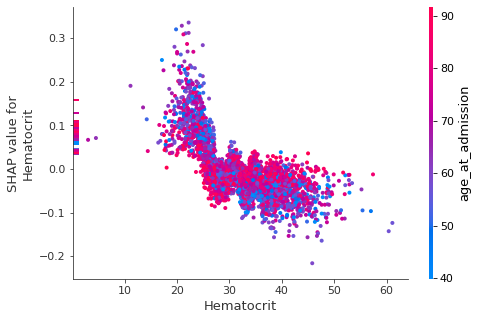

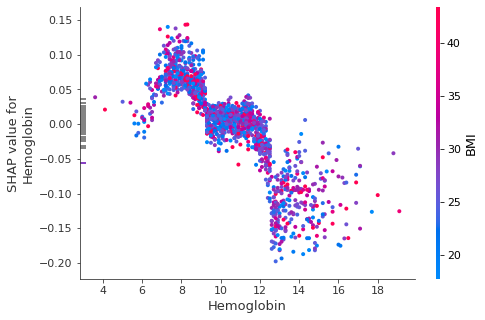

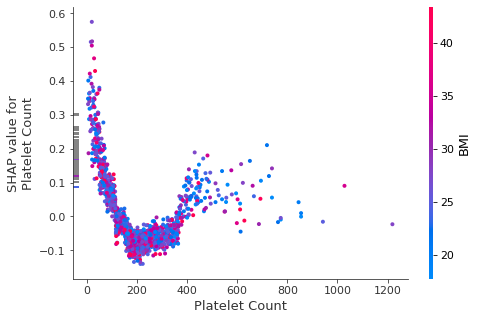

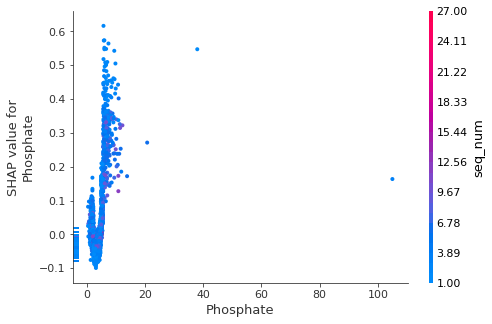

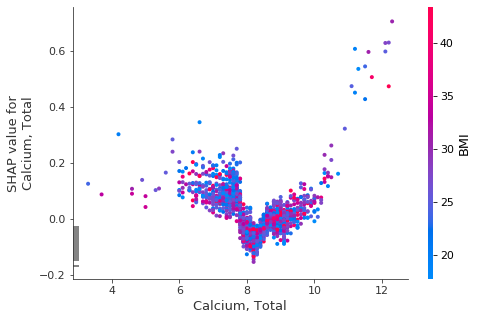

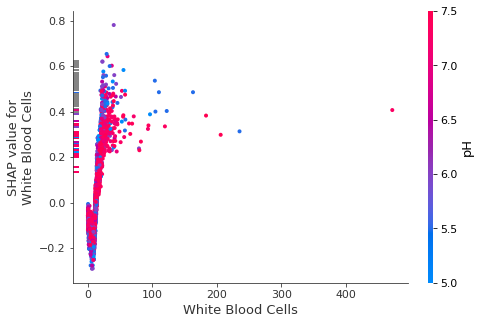

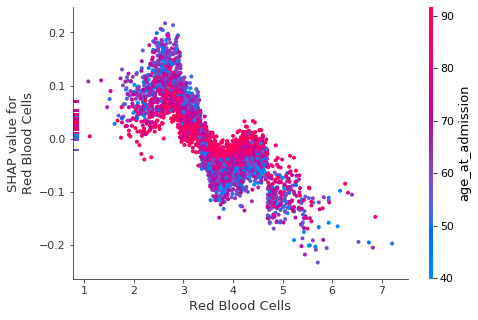

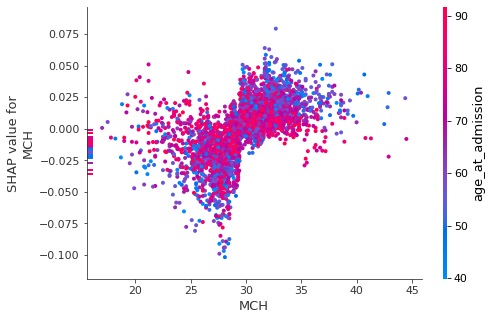

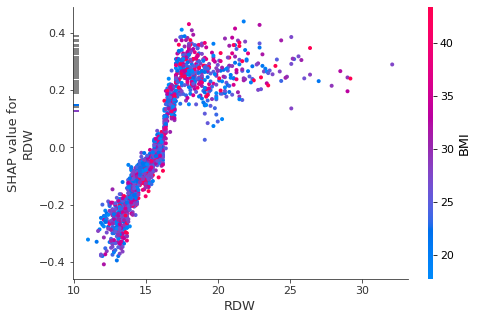

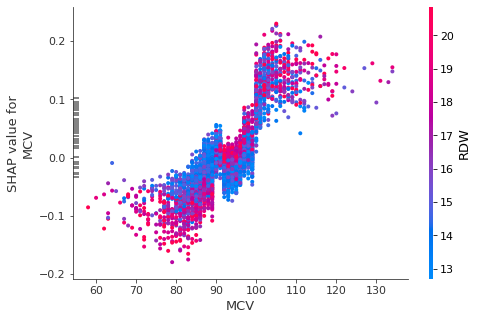

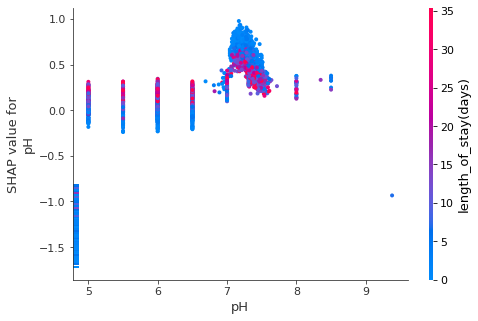

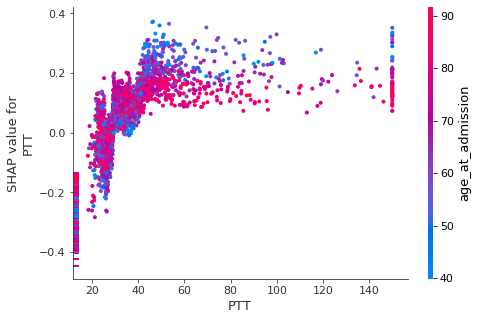

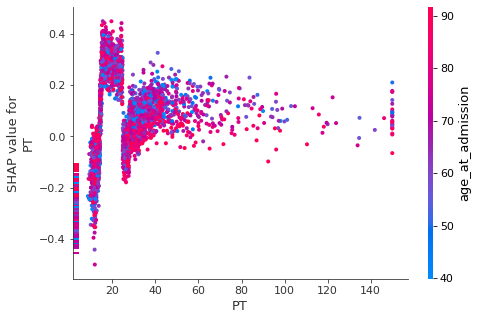

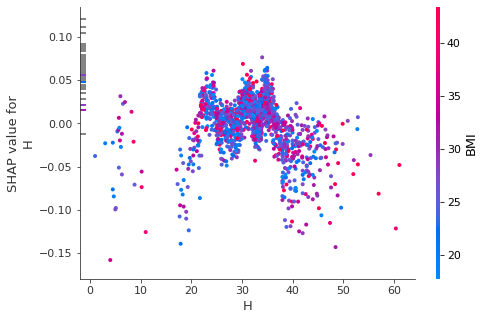

In [10]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values[1], dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1] ,dataset_no_target ,feature_names=feature_names)